# 机器学习实验 - 神经网络

In [70]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import os
from torchvision.io import read_image
import pandas as pd

## 图片数据集

In [71]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.labels = None
        self.transform = transform
        self.target_transform = target_transform
        self.prefix = img_dir.split('/')[1].split('_')[0]
        if self.prefix == 'train':
            self.is_train = True
        else:
            self.is_train = False
        self.initialize_labels(img_dir)
        
    def initialize_labels(self, img_dir):
        self.labels = [-1] * len(os.listdir(self.img_dir))
        for file in os.listdir(self.img_dir):
            segments = file.split('_')
            idx = int(segments[1])
            label = int(segments[2].split('.')[0])
            self.labels[idx] = label
        
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        img_name = self.prefix + '_' + str(idx) + '_' + str(self.labels[idx]) + '.jpg'
        img_path = os.path.join(self.img_dir, img_name)
        label = self.labels[idx]
        image = read_image(img_path) 
        if self.transform:
            image = self.transform(image.float())
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

## 预处理函数

In [72]:
from torchvision.transforms import ToTensor, Lambda, Compose, Normalize

In [73]:
from torch.utils.data import random_split

In [74]:
target_transform = Lambda(lambda y: torch.zeros(
    10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))

In [75]:
transform = Compose([ Normalize((0.1307,), (0.3081,))])

In [76]:
train_path = 'MNIST_data/train_images'
test_path = 'MNIST_data/test_images'
train_data = CustomImageDataset(train_path, transform=transform)
test_data = CustomImageDataset(test_path, transform=transform)
train_data, validate_data = random_split(train_data, [50000, 10000])

## 搭建卷积神经网络

In [77]:
import torch.nn.functional as F
import torch.optim as optim

In [78]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 10, kernel_size=5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(10, 20, kernel_size=5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
        )
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(320, 50),
            torch.nn.Linear(50, 10),
        )

    def forward(self, x):
        batch_size = x.size(0)
        x = self.conv1(x)  # 一层卷积层,一层池化层,一层激活层(图是先卷积后激活再池化，差别不大)
        x = self.conv2(x)  # 再来一次
        x = x.view(batch_size, -1)  # flatten 变成全连接网络需要的输入 (batch, 20,4,4) ==> (batch,320), -1 此处自动算出的是320
        x = self.fc(x)
        return x  # 最后输出的是维度为10的，也就是（对应数学符号的0~9）

## 训练

In [87]:
model = Net()

In [88]:
batch_size_train = 64
batch_size_test = 64
learning_rate=1e-3
n_epochs = 20

In [89]:
train_iter = DataLoader(train_data, batch_size=batch_size_train, shuffle=True)
test_iter = DataLoader(test_data, batch_size=batch_size_test, shuffle=False)
valid_iter = DataLoader(validate_data, batch_size=batch_size_test, shuffle=False)

In [90]:
criterion = torch.nn.CrossEntropyLoss()  # 交叉熵损失
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # lr学习率，momentum冲量

In [91]:
def train(epoch):
    running_loss = 0.0  # 这整个epoch的loss清零
    running_total = 0
    running_correct = 0
    for batch_idx, data in enumerate(train_iter, 0):
        inputs, target = data
        optimizer.zero_grad()

        # forward + backward + update
        outputs = model(inputs)
        loss = criterion(outputs, target)

        loss.backward()
        optimizer.step()

        # 把运行中的loss累加起来，为了下面300次一除
        running_loss += loss.item()
        # 把运行中的准确率acc算出来
        _, predicted = torch.max(outputs.data, dim=1)
        running_total += inputs.shape[0]
        running_correct += (predicted == target).sum().item()

        if batch_idx % 300 == 299:  # 不想要每一次都出loss，浪费时间，选择每300次出一个平均损失,和准确率
            print('[%d, %5d]: loss: %.3f , acc: %.2f %%'
                  % (epoch + 1, batch_idx + 1, running_loss / 300, 100 * running_correct / running_total))
            running_loss = 0.0  # 这小批300的loss清零
            running_total = 0
            running_correct = 0  # 这小批300的acc清零


In [92]:
def validate():
    correct = 0
    total = 0
    with torch.no_grad():  # 验证集不用算梯度
        for data in valid_iter:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)  # dim = 1 列是第0个维度，行是第1个维度，沿着行(第1个维度)去找1.最大值和2.最大值的下标
            total += labels.size(0)  # 张量之间的比较运算
            correct += (predicted == labels).sum().item()
    acc = correct / total
    print('[%d / %d]: Accuracy on validate set: %.1f %% ' % (epoch+1, n_epochs, 100 * acc))  # 求验证的准确率，正确数/总数
    return acc

## 测试

In [93]:
def test():
    correct = 0
    total = 0
    with torch.no_grad():  # 测试集不用算梯度
        for data in test_iter:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)  # dim = 1 列是第0个维度，行是第1个维度，沿着行(第1个维度)去找1.最大值和2.最大值的下标
            total += labels.size(0)  # 张量之间的比较运算
            correct += (predicted == labels).sum().item()
    acc = correct / total
    print('[%d / %d]: Accuracy on test set: %.1f %% ' % (epoch+1, n_epochs, 100 * acc))  # 求测试的准确率，正确数/总数
    return acc


In [94]:
import matplotlib.pyplot as plt

## 利用验证集来进行超参数选择

[1,   300]: loss: 1.532 , acc: 84.03 %
[1,   600]: loss: 0.188 , acc: 94.86 %
[1 / 20]: Accuracy on validate set: 95.9 % 


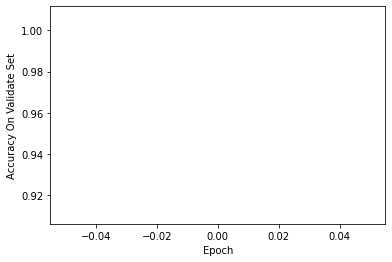

[2,   300]: loss: 0.105 , acc: 97.01 %
[2,   600]: loss: 0.109 , acc: 96.78 %
[2 / 20]: Accuracy on validate set: 97.1 % 


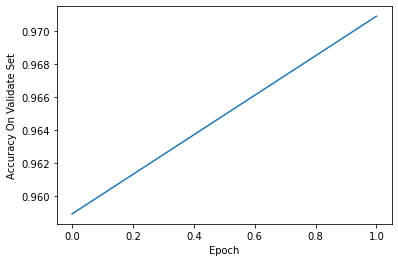

[3,   300]: loss: 0.080 , acc: 97.59 %
[3,   600]: loss: 0.087 , acc: 97.58 %
[3 / 20]: Accuracy on validate set: 97.1 % 


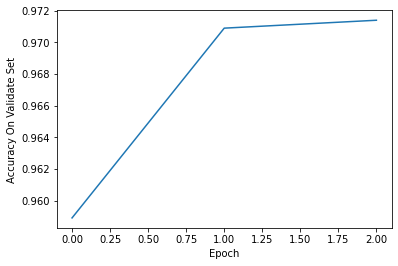

[4,   300]: loss: 0.074 , acc: 97.67 %
[4,   600]: loss: 0.075 , acc: 97.83 %
[4 / 20]: Accuracy on validate set: 97.3 % 


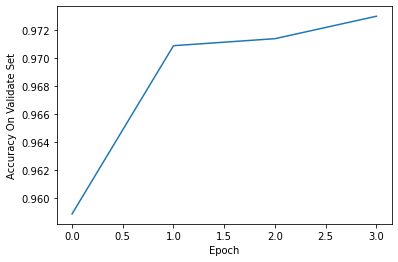

[5,   300]: loss: 0.056 , acc: 98.26 %
[5,   600]: loss: 0.071 , acc: 97.94 %
[5 / 20]: Accuracy on validate set: 97.6 % 


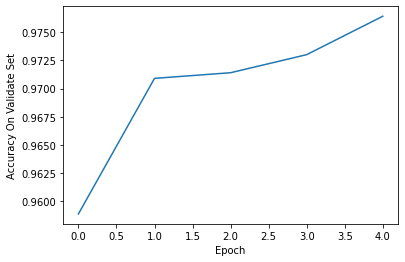

[6,   300]: loss: 0.052 , acc: 98.36 %
[6,   600]: loss: 0.062 , acc: 98.27 %
[6 / 20]: Accuracy on validate set: 97.7 % 


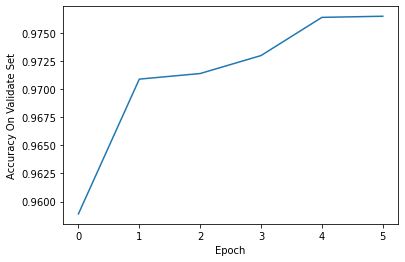

[7,   300]: loss: 0.043 , acc: 98.62 %
[7,   600]: loss: 0.062 , acc: 98.22 %
[7 / 20]: Accuracy on validate set: 97.9 % 


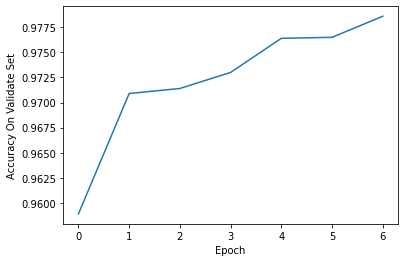

[8,   300]: loss: 0.045 , acc: 98.65 %
[8,   600]: loss: 0.049 , acc: 98.57 %
[8 / 20]: Accuracy on validate set: 97.8 % 


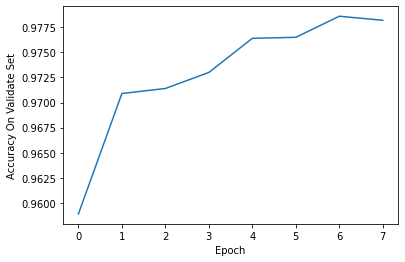

[9,   300]: loss: 0.050 , acc: 98.57 %
[9,   600]: loss: 0.050 , acc: 98.45 %
[9 / 20]: Accuracy on validate set: 97.8 % 


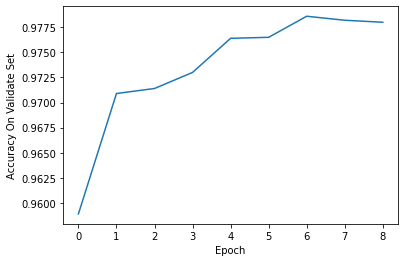

[10,   300]: loss: 0.039 , acc: 98.79 %
[10,   600]: loss: 0.047 , acc: 98.63 %
[10 / 20]: Accuracy on validate set: 97.8 % 


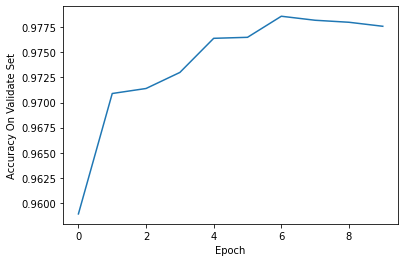

[11,   300]: loss: 0.040 , acc: 98.76 %
[11,   600]: loss: 0.049 , acc: 98.55 %
[11 / 20]: Accuracy on validate set: 97.9 % 


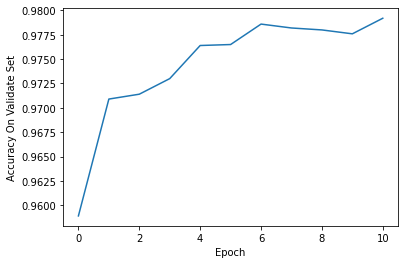

[12,   300]: loss: 0.042 , acc: 98.74 %
[12,   600]: loss: 0.050 , acc: 98.44 %
[12 / 20]: Accuracy on validate set: 97.9 % 


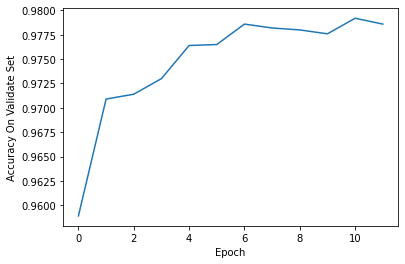

[13,   300]: loss: 0.029 , acc: 99.05 %
[13,   600]: loss: 0.045 , acc: 98.85 %
[13 / 20]: Accuracy on validate set: 98.1 % 


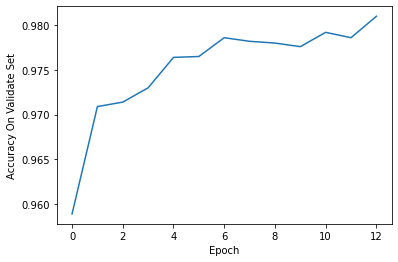

[14,   300]: loss: 0.037 , acc: 98.97 %
[14,   600]: loss: 0.037 , acc: 98.83 %
[14 / 20]: Accuracy on validate set: 97.7 % 


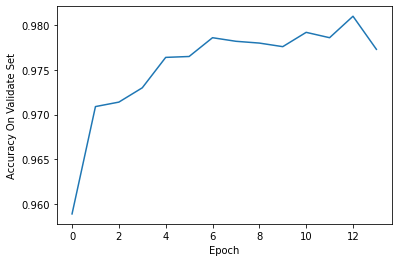

[15,   300]: loss: 0.032 , acc: 99.02 %
[15,   600]: loss: 0.038 , acc: 98.79 %
[15 / 20]: Accuracy on validate set: 98.0 % 


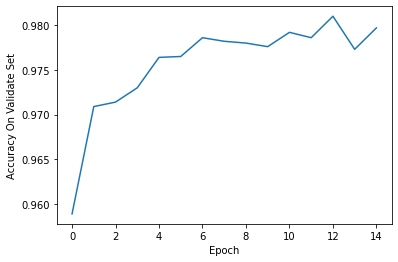

[16,   300]: loss: 0.033 , acc: 99.03 %
[16,   600]: loss: 0.043 , acc: 98.64 %
[16 / 20]: Accuracy on validate set: 98.1 % 


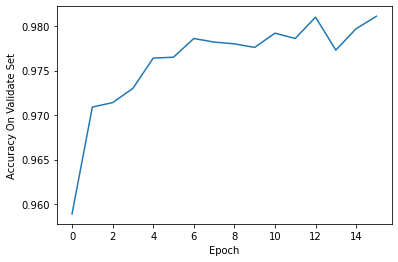

[17,   300]: loss: 0.038 , acc: 98.97 %
[17,   600]: loss: 0.031 , acc: 99.16 %
[17 / 20]: Accuracy on validate set: 98.2 % 


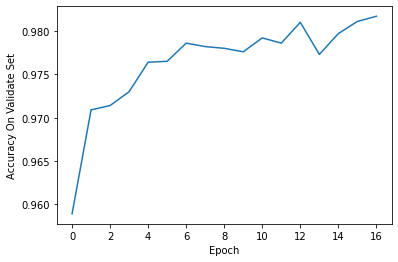

[18,   300]: loss: 0.027 , acc: 99.23 %
[18,   600]: loss: 0.046 , acc: 98.78 %
[18 / 20]: Accuracy on validate set: 98.0 % 


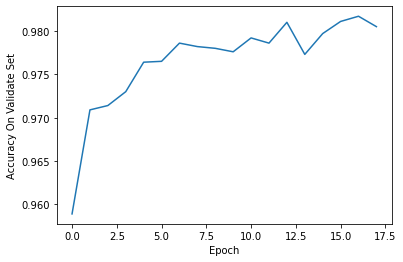

[19,   300]: loss: 0.030 , acc: 99.14 %
[19,   600]: loss: 0.033 , acc: 99.07 %
[19 / 20]: Accuracy on validate set: 98.1 % 


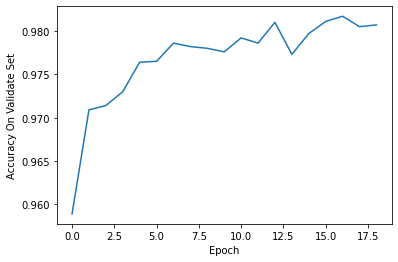

[20,   300]: loss: 0.019 , acc: 99.44 %
[20,   600]: loss: 0.034 , acc: 99.10 %
[20 / 20]: Accuracy on validate set: 98.1 % 


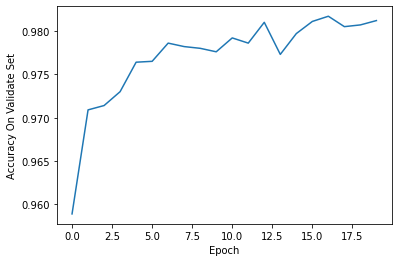

In [95]:
acc_list_valid = []
for epoch in range(n_epochs):
    train(epoch)
    # if epoch % 10 == 9:  #每训练10轮 测试1次
    acc_valid = validate()
    acc_list_valid.append(acc_valid)

    plt.plot(acc_list_valid)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy On Validate Set')
    plt.show()


## 最终训练并测试

In [96]:
final_train_data = CustomImageDataset(train_path, transform=transform)

In [97]:
train_iter = DataLoader(final_train_data, batch_size=batch_size_train, shuffle=True)

In [98]:
for epoch in range(n_epochs):
    train(epoch)
acc = test()

[1,   300]: loss: 0.051 , acc: 98.79 %
[1,   600]: loss: 0.060 , acc: 98.44 %
[1,   900]: loss: 0.041 , acc: 98.81 %
[2,   300]: loss: 0.032 , acc: 99.07 %
[2,   600]: loss: 0.028 , acc: 99.20 %
[2,   900]: loss: 0.042 , acc: 98.81 %
[3,   300]: loss: 0.027 , acc: 99.27 %
[3,   600]: loss: 0.028 , acc: 99.15 %
[3,   900]: loss: 0.042 , acc: 98.83 %
[4,   300]: loss: 0.033 , acc: 99.06 %
[4,   600]: loss: 0.051 , acc: 98.69 %
[4,   900]: loss: 0.042 , acc: 98.80 %
[5,   300]: loss: 0.028 , acc: 99.17 %
[5,   600]: loss: 0.030 , acc: 99.15 %
[5,   900]: loss: 0.039 , acc: 99.06 %
[6,   300]: loss: 0.032 , acc: 99.12 %
[6,   600]: loss: 0.032 , acc: 99.07 %
[6,   900]: loss: 0.034 , acc: 99.06 %
[7,   300]: loss: 0.046 , acc: 98.86 %
[7,   600]: loss: 0.038 , acc: 98.98 %
[7,   900]: loss: 0.031 , acc: 99.21 %
[8,   300]: loss: 0.030 , acc: 99.06 %
[8,   600]: loss: 0.032 , acc: 99.12 %
[8,   900]: loss: 0.034 , acc: 99.09 %
[9,   300]: loss: 0.036 , acc: 99.11 %
[9,   600]: loss: 0.038 ,

In [102]:
# 测试的准确率
print('Accuracy on test set: %.2f %% ' % (100 * acc))

Accuracy on test set: 98.02 % 
